<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> Phyton_kriging:2D variogram </font>
</div>

- **Fecha**: 2023/06/15
        
- **Objetivos**:  Generación del variograma 2D

- **Descripción** Para el variograma hace falta calcular las distancias entre los puntos 2D. Aquí se utiliza la funcion distance.cdist 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

- **Referencias**: -

- **Autores**: 
    - Luis Miguel Sánchez Brea

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import numpy as np

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [25]:
from matplotlib import rcParams

rcParams['figure.dpi'] = 100


In [26]:
from phyton_kriging import np, plt

from phyton_kriging.variogram_2D import theoretical
from phyton_kriging.variogram_2D import experimental
from phyton_kriging.standard_2D import kriging2D

from .utils_math import nearest, nearest2

# Experimental function 



In [27]:
def f_signal(x, y, width=(1,2), sc=0, I0=0, kind=0):
    """Simulation of data

    Args:
        x (np.array): x_positions
        y (np.array): y_positions
        width (float,float): width of gauss function
        sc (float or np.array): random noise
        I0 (float or np.array): detector precision

    Returns:
        y (np.array): data.
    """
    

    match kind:
        case 0:
            z = x + y
        case 1:
            z = np.sin(2 * np.pi * x /width[0]) * np.sin(2 * np.pi * y / width[1]) + x + 0.25*y
        case 2:
            z = np.sin(2 * np.pi * x / 0.5)
        case 3:
            z = 5*np.exp(-(x**2/(2*width[0]**2) + y**2/(2*width[1]**2)))
        case 4:
            z = np.cos(2 * np.pi * np.sqrt(x**2+y**2) / 1) 

    print(z.shape)

    z = z + sc * np.random.randn(*z.shape)
    z = z + 2 * I0 * (np.random.rand(*z.shape) - 0.5)

    return z

In [33]:
def variogram_2D(sensors, hx_var, hy_var, has_draw=True):

    num_sensors=len(sensors)
    positions = np.zeros((num_sensors, 2), dtype=float)
    positions[:, 0] = sensors[:,0]
    positions[:, 1] = sensors[:,1]

    ihx_var = np.arange(0,len(hx_var))
    ihy_var = np.arange(0,len(hy_var))

    variogram = np.zeros((len(ihx_var),len(ihy_var)), dtype=float)   
    num_data = np.zeros((len(ihx_var),len(ihy_var)), dtype=float)   
    

    dist_x = np.abs(positions[:, 0]-positions[:, 0,np.newaxis])
    dist_y = np.abs(positions[:, 1]-positions[:, 1,np.newaxis])

    i_distances_x, _, _ = nearest2(hx_var,dist_x)
    i_distances_y, _, _ = nearest2(hy_var,dist_y)

    #quitar los de abajo, ya que suben el valor de 0 y no cuadra
    i_distances_x = i_distances_x.astype(dtype=float)
    i_distances_y = i_distances_y.astype(dtype=float)
    i_distances_x[np.tril_indices(i_distances_x.shape[0], -1)] = np.nan
    i_distances_y[np.tril_indices(i_distances_y.shape[0], -1)] = np.nan


    for i_h, kx in enumerate(ihx_var):
        for j_h, ky in enumerate(ihy_var):
            print("{}/{}".format(i_h,len(ihx_var)),end='\r')
            has_condition_distance_x = i_distances_x == i_h
            has_condition_distance_y = i_distances_y == j_h

            x_true, y_true = np.where(has_condition_distance_x*has_condition_distance_y)

            n_data = (has_condition_distance_x*has_condition_distance_y).sum()
            num_data[ky,kx] = n_data

            if n_data!=0:
                variogram_j = ((sensors[x_true,2]-sensors[y_true,2])**2).sum()/(2*n_data)
            else:
                variogram_j = None

            variogram[ky,kx]= variogram_j

    if has_draw:
        plt.figure()
        plt.imshow(np.sqrt(variogram), origin='lower',extent=[hx_var[0], hx_var[-1], hy_var[0], hy_var[-1]])
        plt.colorbar()

        plt.figure()
        plt.plot(np.sqrt(variogram[:,0]),'r')
        plt.plot(np.sqrt(variogram[0,:]),'b')
        plt.ylim(0)
        
        plt.figure()
        plt.imshow(num_data, origin='lower')

        plt.colorbar()
        plt.clim(0)
                
    return variogram, num_data

In [34]:
sc = .2
I0 = .0001
width = (2,1)

kind=1

num_x = num_y = 50
num_sensors = num_x * num_y

sensors = np.zeros((num_sensors, 4), dtype=float)
positions = np.zeros((num_sensors, 2), dtype=float)

x = -5 + 10 * np.random.rand(num_sensors)
y = -5 + 10 * np.random.rand(num_sensors)

x = np.linspace(-1, 1, num_x)
y = np.linspace(-1, 1, num_y)

X, Y = np.meshgrid(x, y)
x = X.flatten()
y = Y.flatten()

sensors[:, 0] = x
sensors[:, 1] = y
sensors[:, 2] = f_signal(x, y, width, sc, I0, kind=kind)
sensors[:, 3] = I0 * np.ones_like(x)

positions = np.zeros((num_sensors, 2), dtype=float)

positions[:, 0] = x
positions[:, 1] = y

(2500,)


(50, 50)


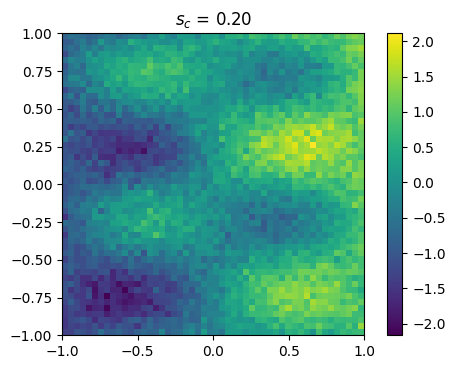

In [35]:
Signal = f_signal(X,Y,width=width, sc=sc, I0=I0, kind=kind)

plt.figure
plt.imshow(Signal, origin='lower', extent=[x[0], x[-1], y[0], y[-1]])

plt.title("$s_c$ = {:2.2f}".format(sc))
plt.colorbar()

In [36]:
hx_var = np.linspace(0,2,21)
hhy_var = np.linspace(0,2,21)

print(hx_var)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]


In [37]:
variogram, num_data = variogram_2D(sensors, hx_var, hhy_var, has_draw=True)